In [ ]:
import re
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score
from gensim.models.fasttext import load_facebook_vectors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import KeyedVectors
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
import torch

In [ ]:
#Cleaning the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

with open("stopwords-el.txt", encoding='utf-8') as f:
    stopwords_el = [clean_text(line) for line in f if line.strip()]

In [ ]:
dataset = load_dataset("DominusTea/GreekLegalSum", split="train")
df = pd.DataFrame(dataset)[['text', 'summary', 'case_category','case_tags']].dropna()
df['text_clean'] = df['text'].apply(clean_text)
df.head()


,text,summary,case_category,case_tags,text_clean
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Αίτηση αναίρεσης καταδικαστικής αποφάσεως για ...,Ακυρότητα απόλυτη,"Αιτιολογίας επάρκεια, Ακυρότητα απόλυτη, Απάτη...",αριθμος \n\nτο δικαστηριο του αρειου παγου\n ...
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Καθορισμός συνολικής ποινής (άρθρο 551 ΚΠΔ) με...,Ποινή συνολική,"Ποινή συνολική, Νόμου εφαρμογή και ερμηνεία, Ε...",αριθμός \n\nτο δικαστηριο του αρειου παγου\n ...
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,Καταδικαστική απόφαση για μη καταβολή χρεών πρ...,Ακυρότητα απόλυτη,"Ακυρότητα απόλυτη, Αοριστία λόγου αναιρέσεως, ...",αριθμός \n\nτο δικαστηριο του αρειου παγου\n\...
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Αναίρεση Εισαγγελέα Αρείου Πάγου κατά αθωωτική...,Αβάσιμοι λόγοι,"Αναιρέσεως απόρριψη, Εισαγγελέας Αρείου Πάγου,...",αριθμός \n\nτο δικαστηριο του αρειου παγου\n\...
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Κατ' εξακολούθηση απάτη κατ' επάγγελμα και κατ...,Αβάσιμοι λόγοι,"Ακυρότητα απόλυτη, Αναιρέσεως απόρριψη, Απάτη,...",αριθμός \n\nτο δικαστηριο του αρειου παγου\n\...


# B2.i


## Exploratory Data Analysis for **case_tags**

6298


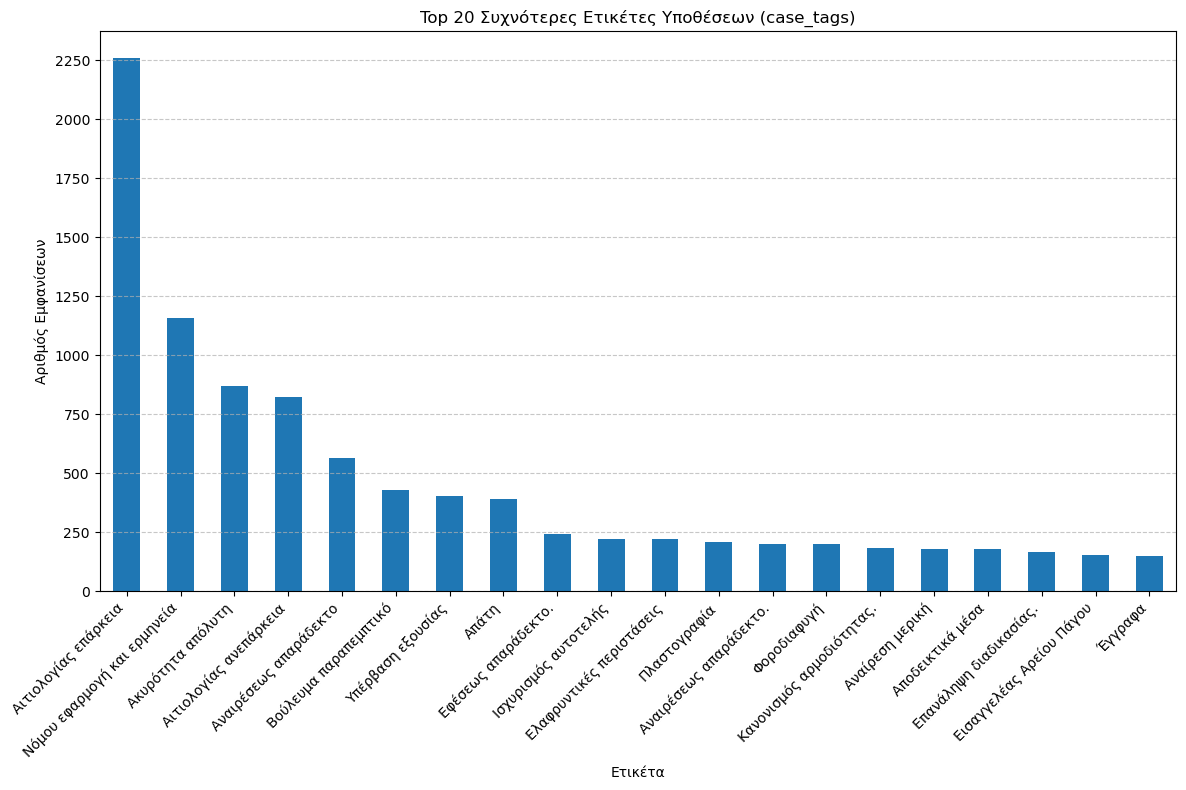

In [ ]:
case_tags_split = df['case_tags'].explode().dropna().astype(str).str.split(',')
print(len(case_tags_split))
case_tags_exploded = case_tags_split.explode().str.strip()
case_tags_counts = case_tags_exploded.value_counts()

plt.figure(figsize=(12, 8))
case_tags_counts.head(20).plot(kind='bar')
plt.title("Top 20 Συχνότερες Ετικέτες Υποθέσεων (case_tags)")
plt.ylabel("Αριθμός Εμφανίσεων")
plt.xlabel("Ετικέτα")
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, case_tags_counts.head(50).max() + 50, 250))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Συμπέρασμα:** Η ετικέτα "Αιτιολογίας επάρκεια" κυριαρχεί με μεγάλη διαφορά, πάνω από 2.250 εμφανίσεις. Αυτό υποδηλώνει ότι ένα μεγάλο ποσοστό των αποφάσεων αφορά ελέγχους σχετικά με την πληρότητα της αιτιολόγησης. Ενώ ακολουθούν οι ετικέτες "Νόμου εφαρμογή και ερμηνεία" και "Ακυρότητα απόλυτη". Τέλος απότομη πτώση μετά την 5η-6η ετικέτα όπου λίγες ετικέτες συγκεντρώνουν το μεγαλύτερο μέρος των περιπτώσεων.

Υπολογισμός πλήθους ετικετών ανά απόφαση...


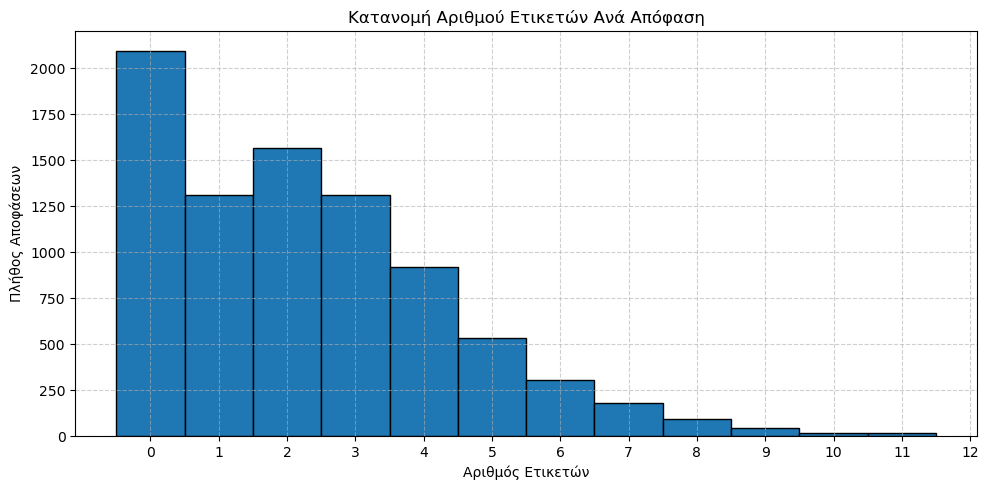

In [ ]:
print("Υπολογισμός πλήθους ετικετών ανά απόφαση...")
df['num_tags'] = df['case_tags'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
plt.figure(figsize=(10, 5))
plt.hist(df['num_tags'], bins=range(0, 13), edgecolor='black', align='left')
plt.title("Κατανομή Αριθμού Ετικετών Ανά Απόφαση")
plt.xlabel("Αριθμός Ετικετών")
plt.ylabel("Πλήθος Αποφάσεων")
plt.xticks(np.arange(0, 13, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Υπολογισμός πλήθους αποφάσεων με κενό ή null case_tags
empty_tags_count = df['case_tags'].isna().sum()
print(f"Αριθμός αποφάσεων με κενό case_tags: {empty_tags_count}")


Αριθμός αποφάσεων με κενό case_tags: 2097


**Συμπέρασμα:** Μεγάλο ποσοστό αποφάσεων (2.097) δεν φέρει καθόλου ετικέτες (0 tags), αυτό μπορεί να οφείλεται σε αποφάσεις που δεν εμπίπτουν σε κάποια προκαθορισμένη θεματική. Ενώ η πλειονότητα των αποφάσεων έχει 1 έως 3 ετικέτες, που υποδηλώνει θεματική εστίαση (κάθε απόφαση αφορά συνήθως λίγα νομικά ζητήματα). Τέλος υπάρχουν αποφάσεις με 6+ ετικέτες οι οποιες ειναι σχετικά λίγες, η κατανομή πέφτει απότομα μετά το 4, αυτές ίσως να περιλαμβάνουν πιο πολύπλοκα, πολυθεματικά ή μικτά νομικά ζητήματα.

Υπολογισμός συν-εμφανιζόμενων ετικετών με κανονικοποίηση...


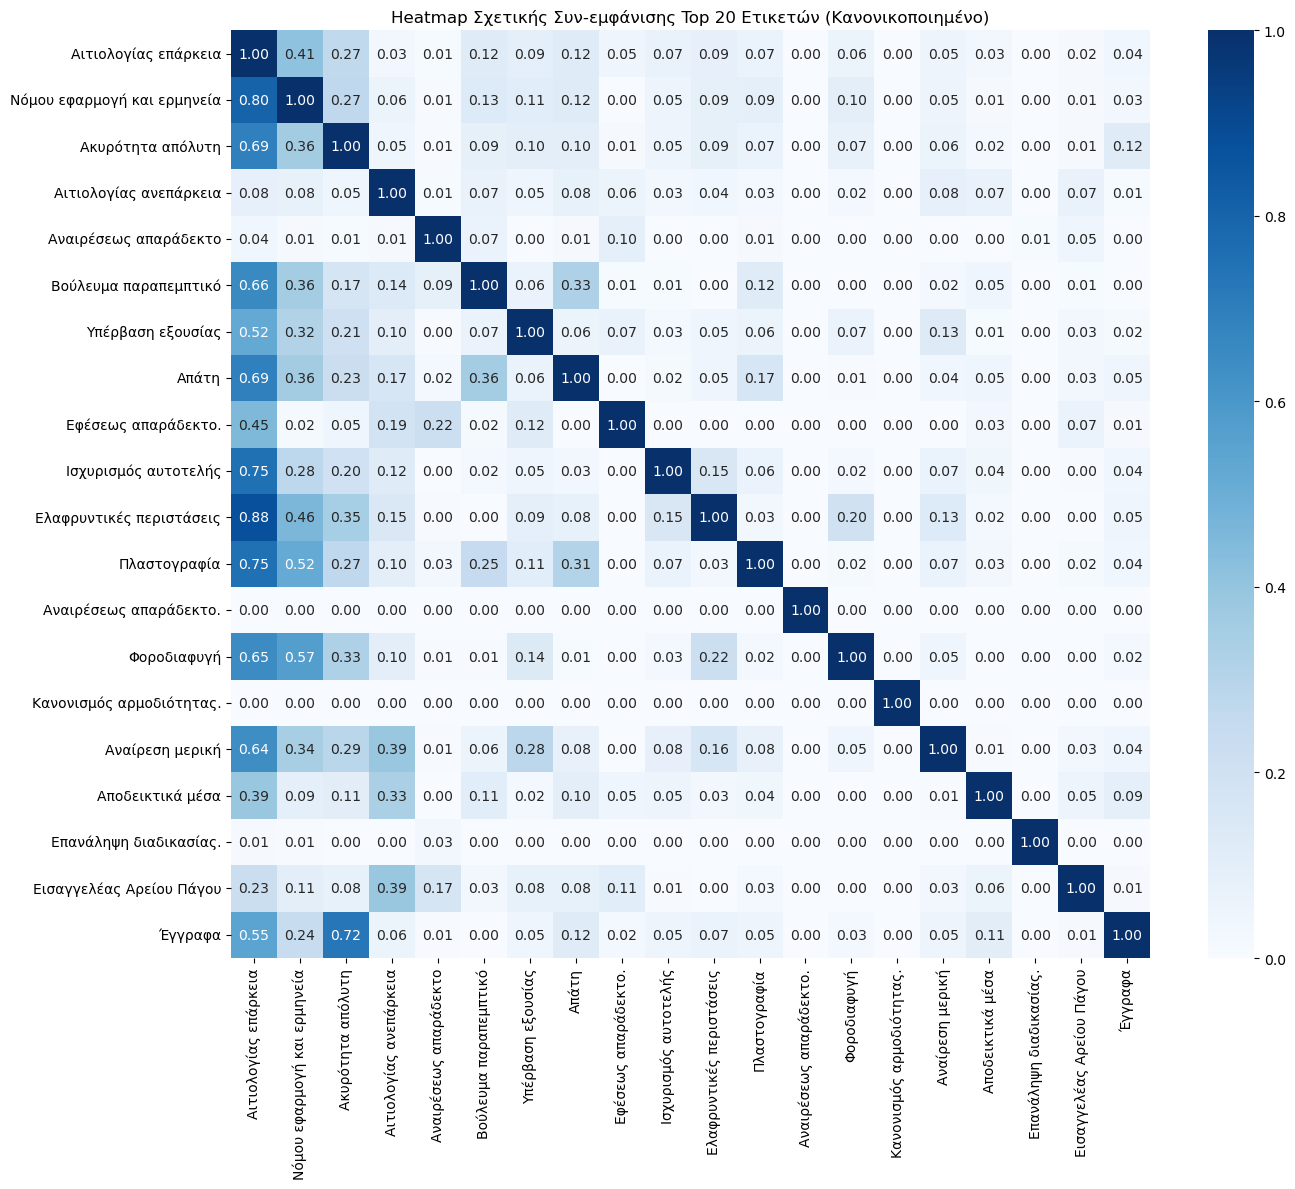

In [ ]:
print("Υπολογισμός συν-εμφανιζόμενων ετικετών με κανονικοποίηση...")
df['clean_tags'] = df['case_tags'].dropna().apply(lambda x: [tag.strip() for tag in str(x).split(',')])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['clean_tags'].dropna())
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Επιλογή Top 30 πιο συχνών ετικετών για ευανάγνωστο heatmap
top_tags = case_tags_counts.head(20).index.tolist()
co_occurrence = tags_df[top_tags].T.dot(tags_df[top_tags])
co_occurrence_pct = co_occurrence.div(co_occurrence.max(axis=1), axis=0)

plt.figure(figsize=(14, 12))
sns.heatmap(co_occurrence_pct, cmap="Blues", annot=True, fmt=".2f")
plt.title("Heatmap Σχετικής Συν-εμφάνισης Top 20 Ετικετών (Κανονικοποιημένο)")
plt.tight_layout()
plt.show()


**Συμπέρασμα:** Το heatmap δείχνει ότι η "Αιτιολογίας επάρκεια" συσχετίζεται έντονα με σχεδόν όλες τις επόμενες πιο συχνές ετικέτες(διαγραμμα 1), όπως η "Νόμου εφαρμογή και ερμηνεία" (0.80), η "Ακυρότητα απόλυτη" (0.69) και η "Αιτιολογίας ανεπάρκεια" (0.63). Η συμπεριφορά αυτή είναι απόλυτα λογική και αναμενόμενη, καθώς οι αποφάσεις που ελέγχουν την επάρκεια αιτιολόγησης συχνά εμπλέκουν και άλλες μορφές νομικής πλημμέλειας ή ερμηνευτικής απόκλισης. Καθώς κατεβαίνουμε σε λιγότερο συχνές ετικέτες, παρατηρείται και σταδιακή μείωση της συσχέτισης.

Συνεπώς, το heatmap λειτουργεί επιβεβαιωτικά για το γράφημα συχνοτήτων, ενισχύοντας την ιδέα ότι υπάρχει μια πυκνή «δικτύωση» ανάμεσα στις πιο δημοφιλείς έννοιες, η οποία όμως εξασθενεί σταδιακά όσο απομακρυνόμαστε από τις συχνότερες ετικέτες.

## Exploratory Data Analysis for **case_category**

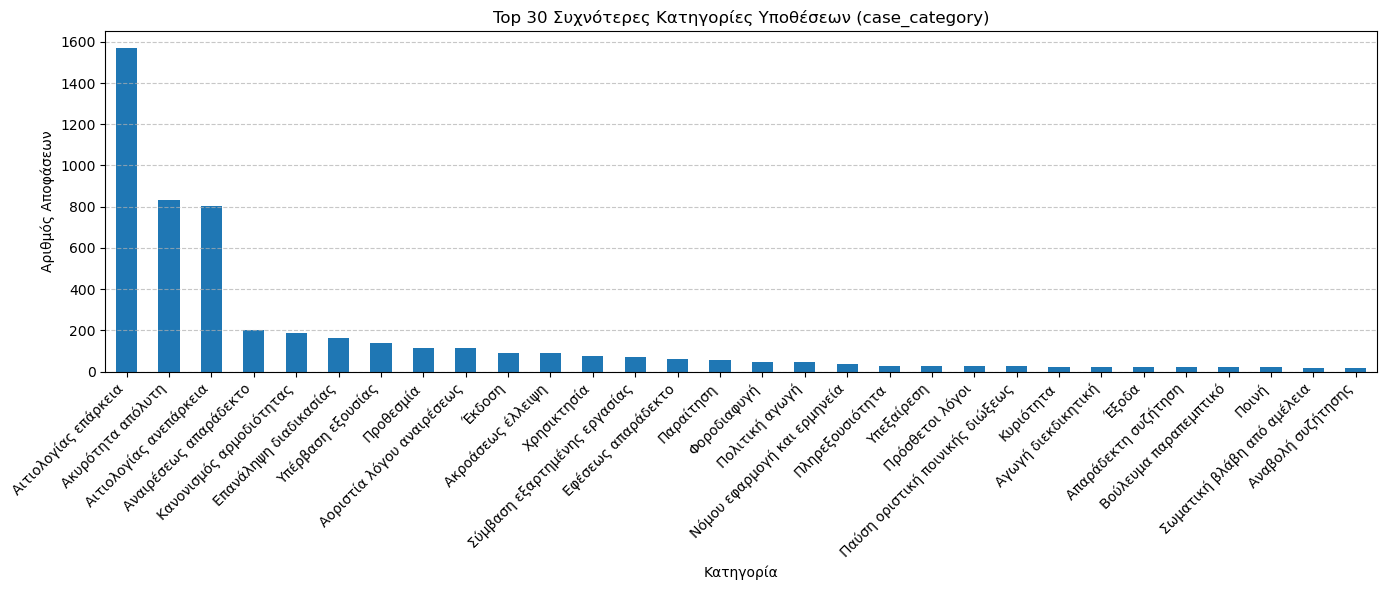

In [ ]:
case_category_counts = df['case_category'].value_counts()
plt.figure(figsize=(14, 6))
case_category_counts.head(30).plot(kind='bar')
plt.title("Top 30 Συχνότερες Κατηγορίες Υποθέσεων (case_category)")
plt.ylabel("Αριθμός Αποφάσεων")
plt.xlabel("Κατηγορία")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Ανάλυση συγκεκριμένης κατηγορίας
target_category = "Αναβολή συζήτησης"  # μπορείς να αλλάξεις το όνομα
count = df[df['case_category'] == target_category].shape[0]
print(f"Η κατηγορία '{target_category}' εμφανίζεται σε {count} αποφάσεις.")


Η κατηγορία 'Αναβολή συζήτησης' εμφανίζεται σε 20 αποφάσεις.


**Συμπεράσματα:** Η ανάλυση της συχνότητας εμφάνισης των κατηγοριών υποθέσεων αποκαλύπτει μια εξαιρετικά άνιση κατανομή. Συγκεκριμένα οι τρεις πρώτες κατηγορίες συγκεντρώνουν υπερπολλαπλάσιο αριθμό αποφάσεων (με την πρώτη να ξεπερνά τις 1.600). Από την 4η θέση και κάτω, παρατηρείται μια κατακόρυφη πτώση, ενδεικτικά, η 30ή πιο συχνή κατηγορία, "Αναβολή συζήτησης", καταγράφει μόλις 20 αποφάσεις

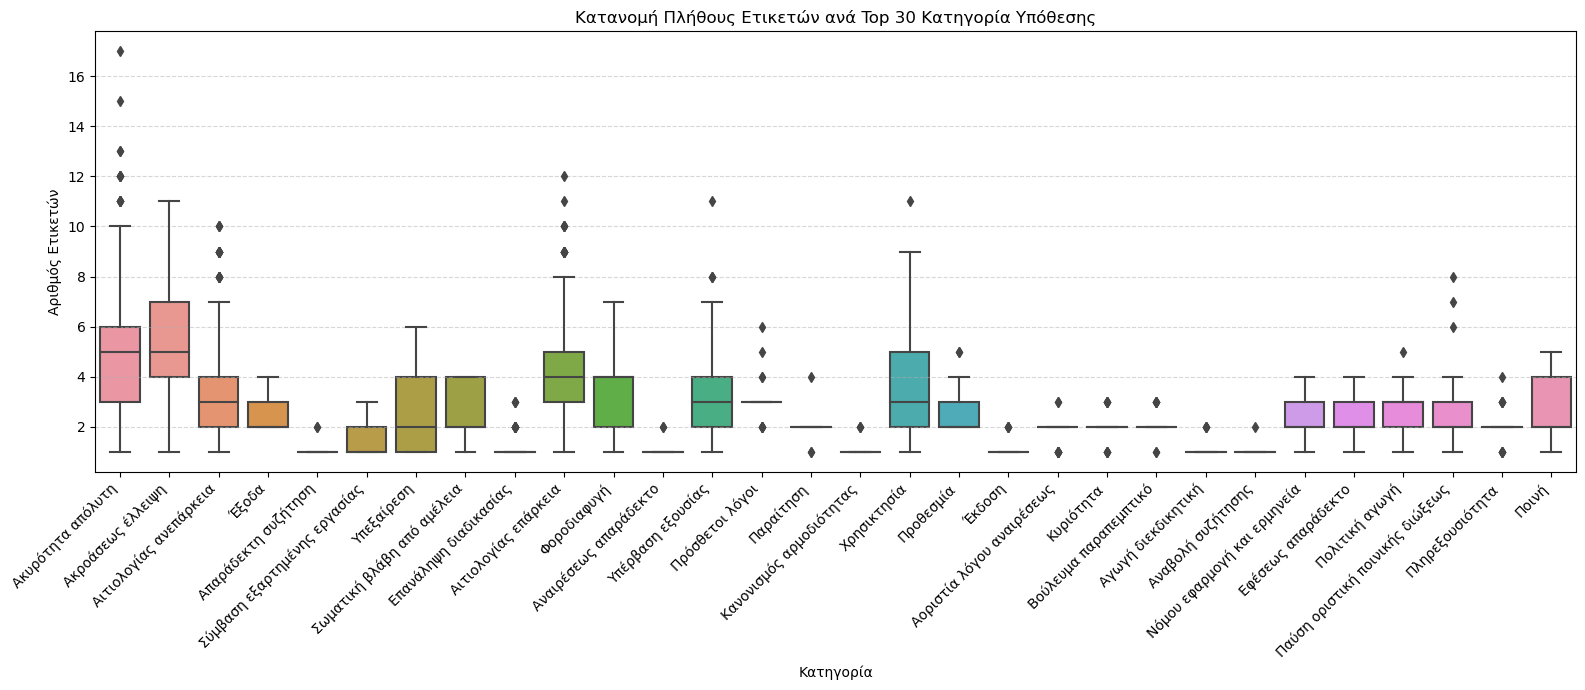

In [ ]:
top_30_categories = case_category_counts.head(30).index.tolist()
plt.figure(figsize=(16, 7))
sns.boxplot(data=df[df['case_category'].isin(top_30_categories) & (df['num_tags'] > 0)],
            x='case_category', y='num_tags')
plt.xticks(rotation=45, ha='right')
plt.title("Κατανομή Πλήθους Ετικετών ανά Top 30 Κατηγορία Υπόθεσης")
plt.ylabel("Αριθμός Ετικετών")
plt.xlabel("Κατηγορία")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Συμπεράσματα:** Το συγκεκριμένο γράφημα αναδεικνύει τη θεματική πολυπλοκότητα των υποθέσεων με βάση τον αριθμό ετικετών (case_tags) που συνοδεύουν κάθε κατηγορία απόφασης. Ορισμένες κατηγορίες παρουσιάζουν σαφώς αυξημένο πλήθος ετικετών ,οπως  "Ακυρότητα απόλυτη", "Ακροάσεως έλλειψη" και "Αιτιολογίας ανεπάρκεια", έχουν όχι μόνο υψηλούς μέσους όρους αλλά και ευρύ εύρος τιμών. Αυτό υποδηλώνει ότι οι αποφάσεις σε αυτές τις κατηγορίες αγγίζουν πολλά διαφορετικά νομικά θέματα ταυτόχρονα. Άλλες κατηγορίες, όπως "Απαράδεκτη συζήτηση" ή "Αναβολή συζήτησης", εμφανίζουν σταθερά χαμηλό αριθμό ετικετών, αυτό δείχνει ότι είναι θεματικά περιορισμένες. Τέλος, η παρουσία πολλών εξαιρέσεων (outliers) σε ορισμένες κατηγορίες (π.χ. τιμές > 10 ετικέτες) μαρτυρά την ύπαρξη αποφάσεων ιδιαίτερης νομικής πολυπλοκότητας.

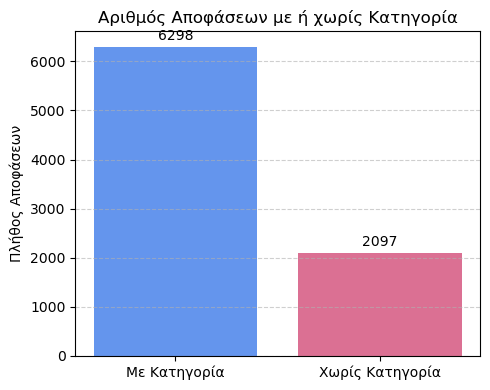

In [ ]:
missing_case_category = df['case_category'].isna().sum()
has_category = len(df) - missing_case_category
plt.figure(figsize=(5, 4))
bars = plt.bar(['Με Κατηγορία', 'Χωρίς Κατηγορία'], [has_category, missing_case_category], color=['cornflowerblue', 'palevioletred'])
plt.title("Αριθμός Αποφάσεων με ή χωρίς Κατηγορία")
plt.ylabel("Πλήθος Αποφάσεων")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Προσθήκη τιμών πάνω από τις μπάρες
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Συμπεράσματα:** Από τις 8.395 συνολικές αποφάσεις, οι 6.298 έχουν διαθέσιμο πεδίο case_category, ενώ οι 2.097 δεν περιλαμβάνουν κατηγορία, το ποσοστό αυτό είναι αξιοσημείωτο.

Δημιουργία heatmap για case_category × case_tags...


C:\Users\Maria\AppData\Local\Temp\ipykernel_9548\4233939900.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cross_tab = cross_tab.fillna(0).astype(int)


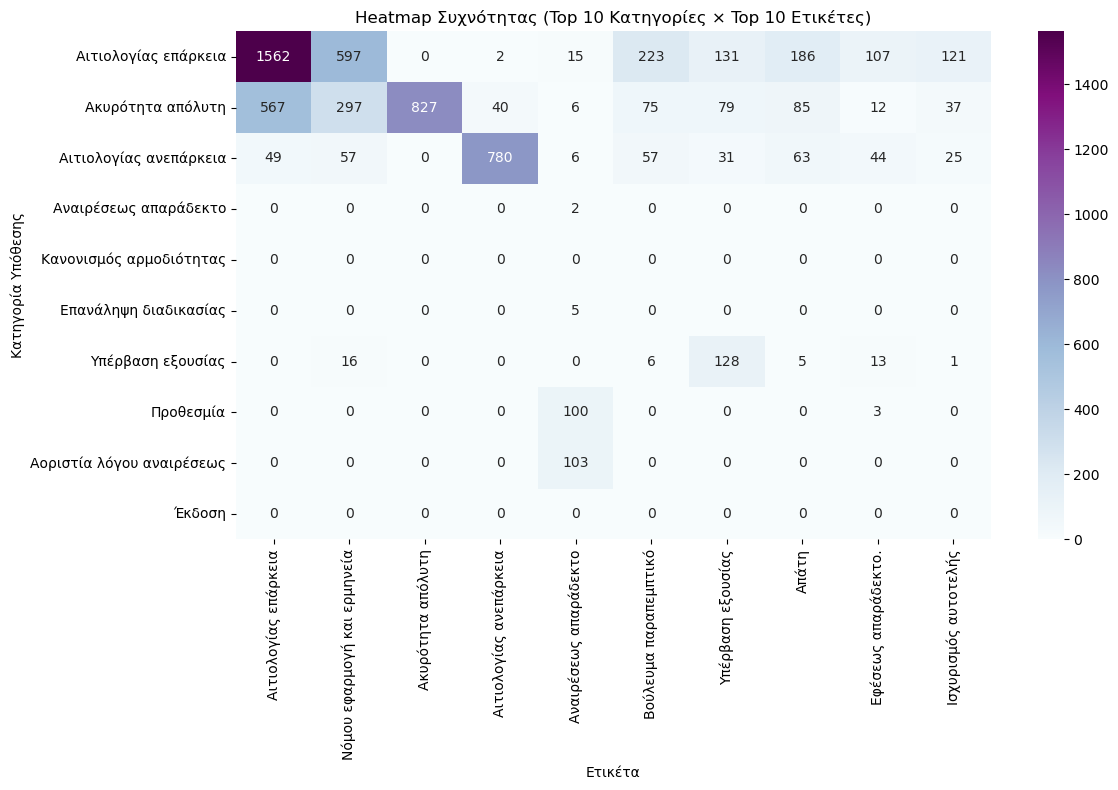

In [ ]:
print("Δημιουργία heatmap για case_category × case_tags...")
df['clean_tags'] = df['case_tags'].dropna().apply(lambda x: [tag.strip() for tag in str(x).split(',')])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['clean_tags'].dropna())
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

top_10_tags = tags_df.sum().sort_values(ascending=False).head(10).index.tolist()
top_10_categories = case_category_counts.head(10).index.tolist()

cross_tab = pd.DataFrame(index=top_10_categories, columns=top_10_tags)

for cat in top_10_categories:
    subset = df[df['case_category'] == cat]
    tag_list = subset['clean_tags'].dropna()
    flattened = [tag for tags in tag_list for tag in tags]
    tag_counts = pd.Series(flattened).value_counts()
    for tag in top_10_tags:
        cross_tab.loc[cat, tag] = tag_counts.get(tag, 0)

cross_tab = cross_tab.fillna(0).astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="BuPu")
plt.title("Heatmap Συχνότητας (Top 10 Κατηγορίες × Top 10 Ετικέτες)")
plt.ylabel("Κατηγορία Υπόθεσης")
plt.xlabel("Ετικέτα")
plt.tight_layout()
plt.show()

**Συμπεράσματα:** Η κατηγορία "Αιτιολογίας επάρκεια" έχει τη μεγαλύτερη συνολική συμμετοχή και συνδέεται άμεσα με την ομώνυμη ετικέτα (1562), αλλά και με άλλες συχνές ετικέτες όπως "Νόμου εφαρμογή και ερμηνεία" (597), "Αναίρεσης απαράδεκτο" (223) και "Βούλευμα παραπεμπτικό" (186). Πολλές από τις υπόλοιπες κατηγορίες (π.χ. "Αναίρεσης απαράδεκτο", "Έκδοση") εμφανίζουν μηδενική ή ελάχιστη σύνδεση με τις κορυφαίες ετικέτες. Αυτό υποδεικνύει ότι συνδέονται με σπανιότερες ετικέτες που δεν εμφανίζονται εδώ.

# B2.ii

In [ ]:
# Convert case_tags to list of tags
df['case_tags'] = df['case_tags'].fillna('').apply(
    lambda x: [tag.strip() for tag in x.split(',')] if isinstance(x, str) else x
)

# Filtering the tags
all_tags = [tag for tags in df['case_tags'] for tag in tags]
tag_counts = Counter(all_tags)
valid_tag_set = {tag for tag, count in tag_counts.items() if count >= 5}

#filtering the categories
cat_counts = df['case_category'].value_counts()
valid_cats = cat_counts[cat_counts >= 5].index

def has_valid_tag(tag_list):
    return any(tag in valid_tag_set for tag in tag_list)

# filtering the DataFrame
df_filtered = df[
    df['case_category'].isin(valid_cats) &
    df['case_tags'].apply(has_valid_tag)
].copy()

## Test Embeddings

**Σημέιωση:** Για την αξιολόγηση των embedding χρησιμοποιήσα το case_category γιατί είναι single-label classification, που δουλεύει άμεσα με LinearSVC, σε σχεση με το case_tags που είναι multimodel.

In [ ]:
X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

#TF-IDF Vectorization
print("Vectorizing texts with TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, stop_words=stopwords_el)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

#SVM Classification
print("Training SVM...")
svm = LinearSVC()
svm.fit(X_train_vec, y_train)
y_pred = svm.predict(X_test_vec)



metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + TF-IDF'])

display(metrics_df)

Vectorizing texts with TF-IDF...
Training SVM...


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
SVM + TF-IDF,0.692573,0.300777,0.287,0.282042,0.637868,0.692573,0.650244


In [ ]:
stopwords_el = set(stopwords_el)

X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# loading the fastText model
print("Loading fastText model...")
ft_model = load_facebook_vectors("cc.el.300.bin")

# Compute embeddings
def compute_embeddings(texts, model, stopwords, dim=300):
    vectors = []
    for doc in texts:
        tokens = [w for w in doc.split() if w not in stopwords and w in model]
        if tokens:
            vec = np.mean([model[w] for w in tokens], axis=0)
        else:
            vec = np.zeros(dim)
        vectors.append(vec)
    return np.array(vectors)

print(" Computing embeddings...")
X_train_vecs = compute_embeddings(X_train_texts, ft_model, stopwords_el)
X_test_vecs = compute_embeddings(X_test_texts, ft_model, stopwords_el)

# SVM Classification
print("Training SVM...")
clf = LinearSVC()
clf.fit(X_train_vecs, y_train)
y_pred = clf.predict(X_test_vecs)

metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + fastText'])

display(metrics_df)


Loading fastText model...
 Computing embeddings...
Training SVM...


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
SVM + fastText,0.363558,0.04822,0.037134,0.030146,0.261255,0.363558,0.237708


In [ ]:
stopwords_el = set(stopwords_el)

X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# loading the Word2Vec model
print("Loading Word2Vec embeddings...")
model = KeyedVectors.load_word2vec_format("cc.el.300.vec", binary=False)
dim = model.vector_size

# Compute embeddings
def text_to_vector(text, model, stopwords, dim):
    words = re.findall(r'\w+', text.lower())
    words = [w for w in words if clean_text(w) not in stopwords]
    vectors = [model[w] for w in words if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

print("Vectorizing texts...")
X_train_vecs = np.stack([text_to_vector(t, model, stopwords_el, dim) for t in X_train_texts])
X_test_vecs = np.stack([text_to_vector(t, model, stopwords_el, dim) for t in X_test_texts])

# SVM Classification
print(" Training SVM...")
svm = LinearSVC()
svm.fit(X_train_vecs, y_train)
y_pred = svm.predict(X_test_vecs)

metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + Word2Vec'])

display(metrics_df)


Loading Word2Vec embeddings...
Vectorizing texts...
 Training SVM...


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
SVM + Word2Vec,0.3821,0.044382,0.041015,0.035289,0.274264,0.3821,0.26369


In [ ]:
stopwords_el = set(stopwords_el)

X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Loading GloVe embeddings
print(" Loading GloVe vectors...")
glove_path = "glove.6B.300d.txt"
embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
dim = len(vector)

# Compute embeddings
def text_to_vector_glove(text, embeddings, stopwords, dim):
    words = re.findall(r'\w+', text.lower())
    words = [w for w in words if clean_text(w) not in stopwords]
    vectors = [embeddings[w] for w in words if w in embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

print("Vectorizing texts...")
X_train_vecs = np.stack([text_to_vector_glove(t, embeddings_index, stopwords_el, dim) for t in X_train_texts])
X_test_vecs = np.stack([text_to_vector_glove(t, embeddings_index, stopwords_el, dim) for t in X_test_texts])

# SVM Classification
print("Training SVM...")
svm = LinearSVC()
svm.fit(X_train_vecs, y_train)
y_pred = svm.predict(X_test_vecs)

metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + GloVe'])

display(metrics_df)


 Loading GloVe vectors...
Vectorizing texts...
Training SVM...


c:\Users\Maria\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
SVM + GloVe,0.291738,0.044934,0.037419,0.035107,0.191106,0.291738,0.194996


## Find the best K for K-means

In [ ]:
print("Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords_el)
X_all = vectorizer.fit_transform(df_filtered['text_clean'])

Vectorizing with TF-IDF...


Evaluating KMeans for different K values...


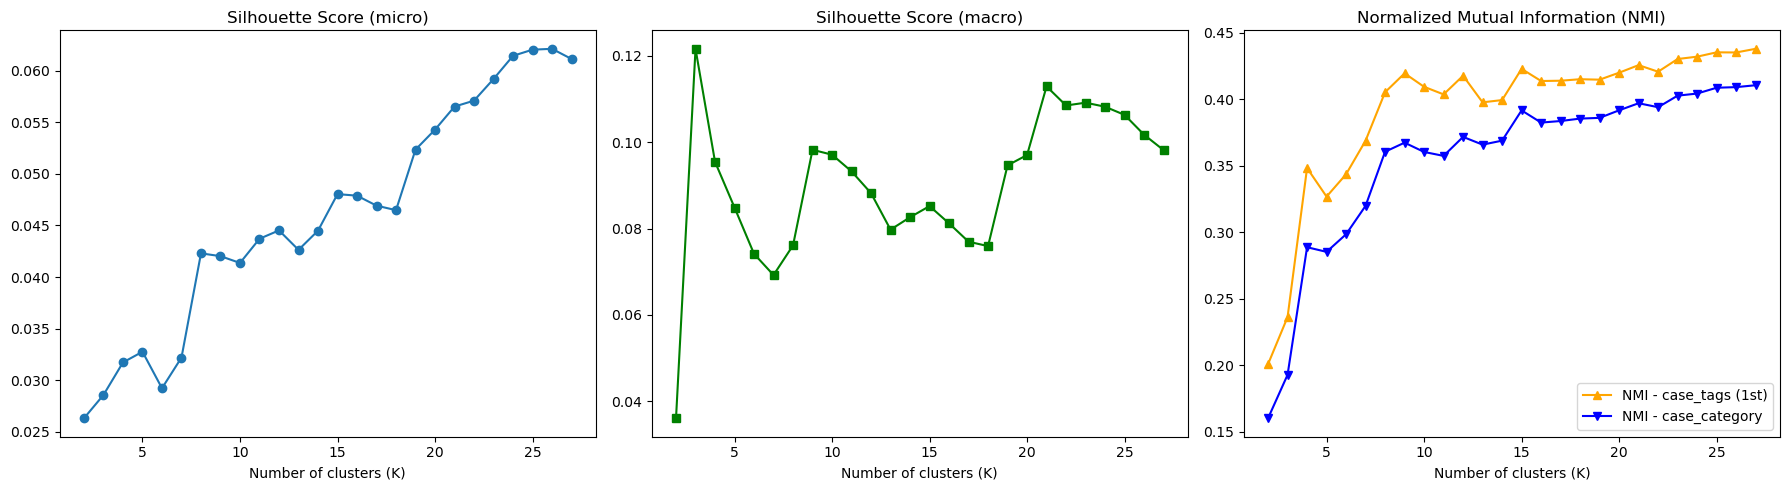

In [ ]:
le_cat = LabelEncoder()
y_cat = le_cat.fit_transform(df_filtered['case_category'])

df_filtered['tag_single'] = df_filtered['case_tags'].apply(lambda tags: tags[0] if tags else 'NO_TAG')
le_tag = LabelEncoder()
y_tag = le_tag.fit_transform(df_filtered['tag_single'])

# KMeans Clustering
k_values = list(range(2, 28))
sil_scores = []
macro_scores = []
nmi_scores_cat = []
nmi_scores_tag = []

print("Evaluating KMeans for different K values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_all)

    # Silhouette (micro)
    sil = silhouette_score(X_all, cluster_labels)

    # Silhouette (macro)
    sample_sil = silhouette_samples(X_all, cluster_labels)
    macro_sil = np.mean([
        sample_sil[cluster_labels == label].mean()
        for label in np.unique(cluster_labels)
        if np.sum(cluster_labels == label) > 1
    ]) if len(np.unique(cluster_labels)) > 1 else 0

    # NMI
    nmi_cat = normalized_mutual_info_score(y_cat, cluster_labels)
    nmi_tag = normalized_mutual_info_score(y_tag, cluster_labels)

    # Save scores
    sil_scores.append(sil)
    macro_scores.append(macro_sil)
    nmi_scores_cat.append(nmi_cat)
    nmi_scores_tag.append(nmi_tag)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_values, sil_scores, marker='o')
axes[0].set_title("Silhouette Score (micro)")
axes[0].set_xlabel("Number of clusters (K)")

axes[1].plot(k_values, macro_scores, marker='s', color='green')
axes[1].set_title("Silhouette Score (macro)")
axes[1].set_xlabel("Number of clusters (K)")

axes[2].plot(k_values, nmi_scores_tag, marker='^', color='orange', label='NMI - case_tags (1st)')
axes[2].plot(k_values, nmi_scores_cat, marker='v', color='blue', label='NMI - case_category')
axes[2].set_title("Normalized Mutual Information (NMI)")
axes[2].set_xlabel("Number of clusters (K)")
axes[2].legend()

plt.tight_layout()
plt.show()

- Silhouette Score (micro): Αυξάνεται σταδιακά, κορυφή στο K=25.

- Silhouette Score (macro): Υψηλότερες τιμές στο K=3,21.

- NMI: Σταθεροποίηση μετά το K=15,στο K=21 παρατηρείτε παλι μια μικρή αύξηση,καλύτερη συσχέτιση με case_tags.

 t-SNE...


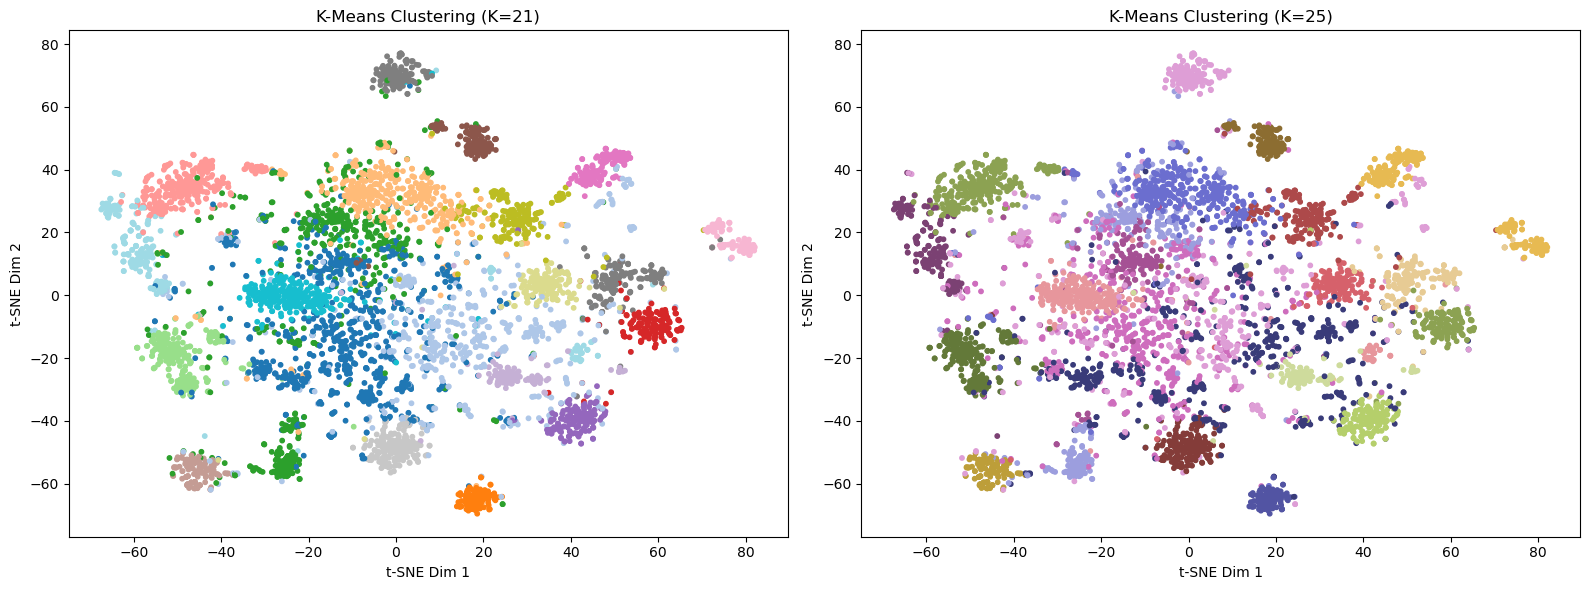

In [ ]:
# kmeans with K=21 and K=25
kmeans_21 = KMeans(n_clusters=21, random_state=0, n_init='auto').fit(X_all)
labels_21 = kmeans_21.labels_

kmeans_25 = KMeans(n_clusters=25, random_state=0, n_init='auto').fit(X_all)
labels_25 = kmeans_25.labels_

# t-SNE
print(" t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_embedded = tsne.fit_transform(X_all.toarray())

# Plotting the clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K=21
axes[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_21, cmap='tab20', s=10)
axes[0].set_title("K-Means Clustering (K=21)")
axes[0].set_xlabel("t-SNE Dim 1")
axes[0].set_ylabel("t-SNE Dim 2")

# Plot 2: K=25
axes[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_25, cmap='tab20b', s=10)
axes[1].set_title("K-Means Clustering (K=25)")
axes[1].set_xlabel("t-SNE Dim 1")
axes[1].set_ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.show()


Αριστερό διάγραμμα (K = 21)
- Οι συστάδες είναι πιο συνεκτικές και ισορροπημένες, με αρκετά καθαρό διαχωρισμό.
- Υπάρχει μικρότερη επικάλυψη, γεγονός που διευκολύνει τη θεματική συνοχή και την ερμηνευσιμότητα των ομάδων.

Δεξί διάγραμμα (K = 25)
- Οι συστάδες είναι περισσότερες και μικρότερες, με ορισμένες να είναι πολύ καθαρές περιφερειακά (κυριες αυτες που ειναι μακριά απο το κέντρο)
▸ Παρατηρείται υπερσυσσώρευση και επικάλυψη στο κέντρο, γεγονός που ενδέχεται να υποδεικνύει υπερκατακερματισμό και να δυσκολεύει τη δημιουργία ξεκάθαρων τίτλων.

Συνεπώς, η τιμή K=21 φαίνεται να προσφέρει καλύτερη ισορροπία μεταξύ διακριτότητα και σταθερότητας των συστάδων, κάτι που επιβεβαιώνεται και από τις αντίστοιχες μετρικές Silhouette και NMI

# B2.iii

In [ ]:
kmeans_21 = KMeans(n_clusters=21, random_state=0, n_init='auto').fit(X_all)
labels_21 = kmeans_21.labels_
df_filtered["cluster"] = labels_21

In [ ]:
# Φόρτωση Llama-Krikri
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "ilsp/Llama-Krikri-8B-Instruct",
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True,
)
model = FastLanguageModel.get_peft_model(model)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Unsloth 2025.5.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
def make_prompt(texts):
    example = (
        "Παράδειγμα:\n"
        "Κείμενο: Ο εργαζόμενος απολύθηκε χωρίς προειδοποίηση λόγω απουσιών.\n"
        "Θέμα:\nΑποζημίωση λόγω καταχρηστικής απόλυσης\n\n"
    )
    joined_texts = "\n\n".join(texts)
    return (
        f"{example}"
        f"Κείμενο: {joined_texts}\n"
        "Θέμα:\n"
    )

def get_llm_response(texts):
    prompt = make_prompt(texts)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=100, temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
def extract_main_theme(response):
    matches = re.findall(r"Θέμα[:：]\s*(.*?)(?:\n|\\n|Κείμενο:|$)", response, re.DOTALL)

    if len(matches) > 1:
        theme = matches[1]
        theme_clean = theme.replace("\\n", " ").replace("…", "").strip(" \n.'-\"")

        if len(theme_clean.split()) < 2 or theme_clean.lower() in {"αναιρεσίβλητος", "αγωγή"}:
            return "⚠️ Ασαφές θέμα"
        return theme_clean

    return "⚠️ Δεν εντοπίστηκε θέμα"


In [ ]:
def get_samples_for_cluster(cluster_id, n_samples=3):

    cluster_mask = df_filtered["cluster"] == cluster_id
    cluster_positions = np.where(cluster_mask)[0]

    X_cluster = X_all[cluster_positions]
    centroid = kmeans_21.cluster_centers_[cluster_id].reshape(1, -1)

    distances = pairwise_distances(X_cluster, centroid)
    sorted_indices = np.argsort(distances.ravel())

    closest_pos = cluster_positions[sorted_indices[:n_samples]]
    random_pos = np.random.choice(cluster_positions, size=n_samples, replace=False)

    return df_filtered.iloc[closest_pos]["summary"].tolist(), df_filtered.iloc[random_pos]["summary"].tolist()


In [ ]:
def format_output_single_theme(response, original_texts):
    theme = extract_main_theme(response)
    joined_text = "\n\n".join(original_texts)
    return f"Θέμα:\n{theme}\n\nΤο κείμενο είναι αυτό:\n{joined_text}"

In [ ]:
for cluster_id in range(21):
    close_texts, random_texts = get_samples_for_cluster(cluster_id)

    # LLM responses
    response_close = get_llm_response(close_texts)
    response_random = get_llm_response(random_texts)

    # Main theme extraction
    theme_close = extract_main_theme(response_close)
    theme_random = extract_main_theme(response_random)

    # Output formatting
    print(f"\n==================== Cluster {cluster_id + 1} ====================")

    print("\n➡️ Από αποφάσεις κοντά στο κέντρο:")
    print("Θέμα:")
    print(theme_close)
    print("Το κείμενο είναι αυτό:")
    print("\n\n".join(close_texts))

    print("\n➡️ Από τυχαίες αποφάσεις:")
    print("Θέμα:")
    print(theme_random)
    print("Το κείμενο είναι αυτό:")
    print("\n\n".join(random_texts))



==================== Cluster 1 ====================

➡️ Από αποφάσεις κοντά στο κέντρο:
Θέμα:
Υπερβολική αιτιολογία και υπέρβαση εξουσίας
Το κείμενο είναι αυτό:
Καταδικαστική απόφαση για πλαστογραφία με χρήση κατ' εξακολούθηση. Αντικείμενο πλαστογραφίας είναι και το φωτοτυπικό αντίγραφο εγγράφου. Πότε αρχίζει η κύρια διαδικασία. Προσφυγή κατά του κλητηρίου θεσπίσματος. Όταν γίνει δεκτή η προσφυγή και παραπεμφθεί η υπόθεση στο συμβούλιο, μόνο από την κλήτευση του κατηγορουμένου μετά το παραπεμπτικό βούλευμα αρχίζει η κύρια διαδικασία και επέρχεται η αναστολή της παραγραφής, οπότε, στην περίπτωση αυτή, αίρονται οι συνέπειες από την οποιαδήποτε ακυρότητα της επιδόσεως του κλητηρίου θεσπίσματος. Η μη έγκυρη επίδοση του βουλεύματος καλύπτεται εφόσον ο κατηγορούμενος εμφανισθεί και δεν προβάλλει αντιρρήσεις στην πρόοδο της δίκης. Ακυρότητα κλητεύσεως στο ακροατήριο δεν μπορεί να προταθεί μετά την έναρξη της εκδικάσεως της υποθέσεως, που συντελείται με την απαγγελία της κατηγορίας ή την ανάπ

Unsloth: Input IDs of length 2231 > the model's max sequence length of 2048.
We shall truncate it ourselves. It's imperative if you correct this issue first.



==================== Cluster 5 ====================

➡️ Από αποφάσεις κοντά στο κέντρο:
Θέμα:
Προθεσμίες άσκησης ενδίκων μέσων - Λόγοι ανωτέρας βίας
Το κείμενο είναι αυτό:
Απόρριψη αίτησης αναίρεσης ως απαράδεκτης λόγω εκπρόθεσμης άσκησής της μετά την πάροδο 10ημερης προθεσμίας από την επίδοση σ' αυτόν της προσβαλλόμενης απόφασης, η οποία είχε καταχωρηθεί καθαρογεγραμμένη πριν από την επίδοση σ' αυτόν στο ειδικό βιβλίο που τηρείται στη γραμματεία του εκδώσαντος αυτή δικαστηρίου και μη αναφοράς στην αίτηση λόγων ανωτέρας βίας και ανυπέρβλητου κωλύματος που να δικαιολογούν το εκπρόθεσμο αυτής.

Αίτηση αναιρέσεως. Προθεσμία επί ερήμην αποφάσεως. Αρχίζει από επίδοση της καταχωρηθείσης στο ειδικό βιβλίο αποφάσεως (ΑΠ 619/2005). Αν η καταχώρηση μεταγενέστερη της επίδοσης από την επίδοση (ΑΠ 886/2008, ΑΠ 179/2005). Πως και πότε προβάλλονται οι λόγοι ανωτέρας βίας που δικαιολογούν εκπρόθεσμη άσκηση (ΑΠ 411/2003). Απόρριψη απαράδεκτης αιτήσεως που ασκήθηκε εκπροθέσμως χωρίς να προβάλλεται λόγο